# Seoul Bike Trip Duration Prediction

<img src="Features_Description.png" style="float:right;" width="500"/>

### Context
- Trip duration is the most fundamental measure in all modes of transportation. 
- Hence, it is crucial to predict the trip-time precisely for the advancement of Intelligent Transport Systems (ITS) and traveller information systems. 
- In order to predict the trip duration, data mining techniques are employed in this paper to predict the trip duration of rental bikes in Seoul Bike sharing system. 
- The prediction is carried out with the combination of Seoul Bike data and weather data.

### Content
- The Data used include trip duration, trip distance, pickup-dropoff latitude and longitude, 
temperature, precipitation, wind speed, humidity, solar radiation, snowfall, ground temperature and 1-hour average dust concentration.

### Acknowledgements
- V E, Sathishkumar (2020), "Seoul Bike Trip duration prediction", Mendeley Data, V1, doi: 10.17632/gtfh9z865f.1
- Sathishkumar V E, Jangwoo Park, Yongyun Cho, (2019), Seoul bike trip duration prediction using data mining techniques, IET Intelligent Transport Systems, doi: 10.1049/iet-its.2019.0796

### Goal
- Predict the trip duration

### Steps
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Feature Selection / Transformation
- **Mahcine Learning Algorithm**
- **Feature Importance / Engineering**
- **Hyperparameter Tuning**
- Model Deployment

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from helper_functions import *

from timeit import default_timer as timer

In [2]:
# import sklearn
# sklearn.__version__ #'0.22.1'

## Data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, X_test, y_train, y_val, y_test = \
joblib.load('data/X_train.pkl'),\
joblib.load('data/X_val.pkl'),\
joblib.load('data/X_test.pkl'),\
joblib.load('data/y_train.pkl'),\
joblib.load('data/y_val.pkl'),\
joblib.load('data/y_test.pkl')

rfe_features = X_train.columns

train_dataset = X_train.copy()
train_dataset['Duration'] = y_train

In [4]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7015172, 10), (876896, 10), (876897, 10), (7015172,), (876896,), (876897,))

In [5]:
X_test

,Distance,PLong,DLatd,Haversine,Phour,Pmin,Dhour,Dmin,Temp,Solar
6201544,5990,37.557892,126.927071,1.219944,13,4,14,2,25.6,2.82
1405956,4590,37.535969,127.130028,3.279214,21,35,22,3,19.1,0.00
4726079,3070,37.534424,126.969383,2.173289,11,50,12,3,30.8,0.94
4842874,1800,37.592842,127.002533,1.452439,10,10,10,19,30.6,1.20
6846777,8550,37.496117,127.022652,5.963243,13,18,14,8,17.6,1.89
...,...,...,...,...,...,...,...,...,...,...
5983206,1470,37.575432,126.998535,0.969771,13,29,13,46,26.8,2.60
1639466,6770,37.528816,126.986160,6.275452,13,29,14,4,20.1,3.34
9250871,1610,37.535080,126.970001,1.368987,1,21,1,28,-9.8,0.00
4706693,4640,37.590797,126.915337,1.557050,21,0,21,30,29.7,0.00


### Feature scaling

In [6]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

joblib.dump(scalar, 'models/scalar.joblib')

['models/scalar.joblib']

## Machine Learning Algorithms

In [7]:
def fit_ML_model(modelName, model, error=pd.DataFrame(
    [], index=['Train Loss','Val Loss', 'Test Loss', 'y_mean','Time (s)'])):

    from sklearn.metrics import mean_squared_error
    
    start = timer()
    
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train))**0.5
    rmse_val = mean_squared_error(y_val, model.predict(X_val))**0.5
    rmse_test = mean_squared_error(y_test, model.predict(X_test))**0.5

    end = timer()

    error[modelName] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]

    return model, error

###  Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

modelName = 'LinReg'
lr, error = fit_ML_model(modelName, LinearRegression())

feature_importances = pd.DataFrame(abs(lr.coef_), index=rfe_features, columns=[modelName])
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(lr, 'models/LinReg.pkl', compress=3)

error

,LinReg
Train Loss,12.671839
Val Loss,12.671243
Test Loss,12.625706
y_mean,22.555679
Time (s),3.264922


### Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

modelName = 'RandForest'
rf = RandomForestRegressor(n_estimators=100, min_samples_split=10, n_jobs=-1)
rf, error = fit_ML_model(modelName, rf)

feature_importances[modelName] = rf.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(rf, 'models/RandForest.joblib', compress=3)

error

,LinReg,RandForest
Train Loss,12.671839,2.767901
Val Loss,12.671243,4.700227
Test Loss,12.625706,4.695033
y_mean,22.555679,22.555679
Time (s),3.264922,1112.245057


### XGBoost

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

modelName = 'XGBoost'
xgb = XGBRegressor(learning_rate=0.9, n_estimators=100, n_jobs=-1,
                   tree_method='exact', eval_set=[(X_val, y_val)], 
                   early_stopping_rounds=10, verbose=1)
xgb, error = fit_ML_model(modelName, xgb)

feature_importances[modelName] = xgb.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(xgb, 'models/XGBoost.joblib', compress=3)

error

[03:24:03] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,LinReg,RandForest,XGBoost
Train Loss,12.671839,2.767901,3.644628
Val Loss,12.671243,4.700227,3.720178
Test Loss,12.625706,4.695033,3.722469
y_mean,22.555679,22.555679,22.555679
Time (s),3.264922,1112.245057,276.846586


### Neural Network

In [11]:
import tensorflow as tf
from tensorflow import keras

nodes = 64
n_hidden = 2
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for _ in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))

ann.add(keras.layers.Dense(1))

ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [12]:
epochs = 1000
batch_size = 10000

lr =1e-3 

optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
ann.compile(loss='mean_squared_error', optimizer=optimizer)

checkpoint_cb = keras.callbacks.ModelCheckpoint("models/ANN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

start = timer()
history = ann.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size,
                  callbacks=[checkpoint_cb, early_stopping_cb])

end = timer()

Epoch 1/1000
702/702 [==============================] - 6s 7ms/step - loss: 391.2552 - val_loss: 104.5247
Epoch 2/1000
702/702 [==============================] - 3s 5ms/step - loss: 84.8433 - val_loss: 22.5225
Epoch 3/1000
702/702 [==============================] - 3s 5ms/step - loss: 14.3551 - val_loss: 6.7018
Epoch 4/1000
702/702 [==============================] - 3s 5ms/step - loss: 6.5352 - val_loss: 5.7771
Epoch 5/1000
702/702 [==============================] - 4s 5ms/step - loss: 5.7530 - val_loss: 5.2999
Epoch 6/1000
702/702 [==============================] - 3s 5ms/step - loss: 5.3929 - val_loss: 4.8648
Epoch 7/1000
702/702 [==============================] - 3s 5ms/step - loss: 4.9374 - val_loss: 4.4588
Epoch 8/1000
702/702 [==============================] - 4s 5ms/step - loss: 4.4657 - val_loss: 4.0751
Epoch 9/1000
702/702 [==============================] - 3s 5ms/step - loss: 4.1840 - val_loss: 3.8849
Epoch 10/1000
702/702 [==============================] - 4s 5ms/step - loss

702/702 [==============================] - 3s 5ms/step - loss: 2.7099 - val_loss: 2.6203
Epoch 81/1000
702/702 [==============================] - 4s 5ms/step - loss: 2.6088 - val_loss: 2.6660
Epoch 82/1000
702/702 [==============================] - 3s 5ms/step - loss: 2.6296 - val_loss: 2.6246
Epoch 83/1000
702/702 [==============================] - 4s 5ms/step - loss: 2.6299 - val_loss: 2.6038
Epoch 84/1000
702/702 [==============================] - 4s 5ms/step - loss: 2.6172 - val_loss: 2.5685
Epoch 85/1000
702/702 [==============================] - 4s 5ms/step - loss: 2.6550 - val_loss: 2.5835
Epoch 86/1000
702/702 [==============================] - 4s 5ms/step - loss: 2.6211 - val_loss: 2.5477
Epoch 87/1000
702/702 [==============================] - 4s 5ms/step - loss: 2.5894 - val_loss: 2.5346
Epoch 88/1000
702/702 [==============================] - 4s 5ms/step - loss: 2.5745 - val_loss: 2.5382
Epoch 89/1000
702/702 [==============================] - 3s 5ms/step - loss: 2.5922 - v

702/702 [==============================] - 4s 5ms/step - loss: 1.8922 - val_loss: 1.8791
Epoch 160/1000
702/702 [==============================] - 3s 5ms/step - loss: 1.9085 - val_loss: 1.8799
Epoch 161/1000
702/702 [==============================] - 3s 5ms/step - loss: 1.8449 - val_loss: 1.8489
Epoch 162/1000
702/702 [==============================] - 3s 5ms/step - loss: 1.8837 - val_loss: 1.8685
Epoch 163/1000
702/702 [==============================] - 4s 5ms/step - loss: 1.9005 - val_loss: 1.8523
Epoch 164/1000
702/702 [==============================] - 4s 5ms/step - loss: 1.8821 - val_loss: 1.8526
Epoch 165/1000
702/702 [==============================] - 3s 5ms/step - loss: 1.8748 - val_loss: 1.8490
Epoch 166/1000
702/702 [==============================] - 4s 5ms/step - loss: 1.8460 - val_loss: 1.8424
Epoch 167/1000
702/702 [==============================] - 4s 5ms/step - loss: 1.8748 - val_loss: 1.8693
Epoch 168/1000
702/702 [==============================] - 4s 5ms/step - loss: 1

In [13]:
# still need to find a good way to determine feature importance using NN
# feature_importances['NN_CPU'] =np.mean(abs(ann.weights[0]), axis=1)

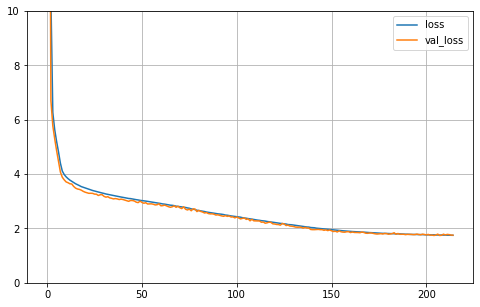

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, ann.predict(X_train, batch_size=batch_size))**0.5
rmse_val = mean_squared_error(y_val, ann.predict(X_val, batch_size=batch_size))**0.5
rmse_test = mean_squared_error(y_test, ann.predict(X_test, batch_size=batch_size))**0.5
error['NN_CPU'] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

,LinReg,RandForest,XGBoost,NN_CPU
Train Loss,12.671839,2.767901,3.644628,1.316589
Val Loss,12.671243,4.700227,3.720178,1.319398
Test Loss,12.625706,4.695033,3.722469,1.306219
y_mean,22.555679,22.555679,22.555679,22.555679
Time (s),3.264922,1112.245057,276.846586,764.643433


### Plotting best results (NN)

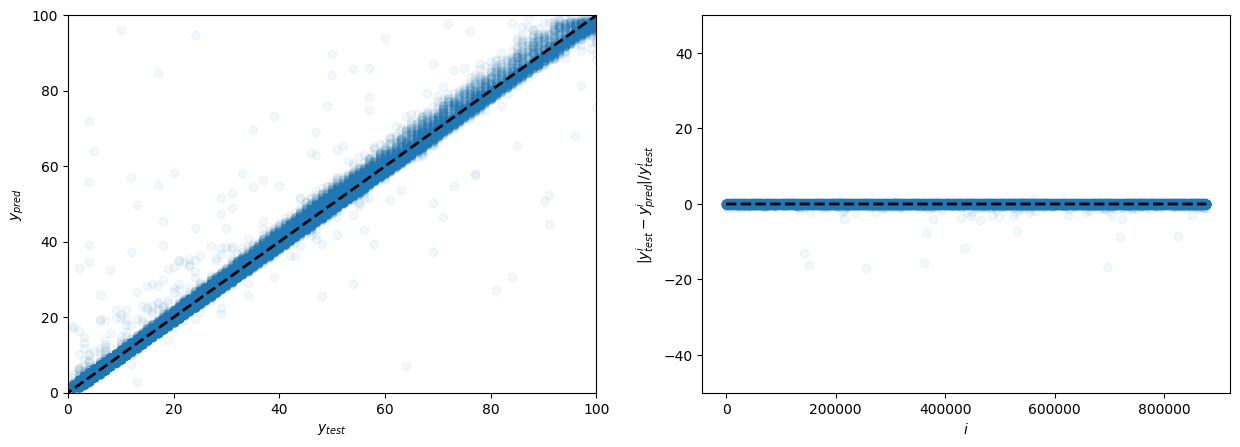

In [15]:
y_pred = ann.predict(X_test, batch_size=batch_size)
rel_res = (y_test.values-y_pred[:,0])/y_test.values

plot_idx = np.random.choice(range(len(y_test)), size=len(y_test)//10, replace=False)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5), dpi=100)

ax[0].scatter(y_test.values[plot_idx], y_pred[:,0][plot_idx], alpha=0.05);
ax[0].set_xlabel('$y_{test}$')
ax[0].set_ylabel('$y_{pred}$')
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[0].plot(range(-10,130), range(-10,130), '--k', lw=2);

ax[1].scatter(np.arange(len(rel_res))[plot_idx], rel_res[plot_idx], alpha=0.05);
ax[1].set_xlabel('$i$')
ax[1].set_ylabel('$|y_{test}^i-y_{pred}^i|/y_{test}^i$');
ax[1].plot(range(len(rel_res)), 0*np.arange(len(rel_res)), '--k', lw=2);
ax[1].set_ylim(-50,50);

# sns.kdeplot(y_test.values-y_pred[:,0], ax=ax[1], shade=True)
# ax[1].set_xlim(-50,50);

## Feature Importance

In [16]:
df_corr = train_dataset.corr()
feature_importances['Duration_Corr'] = df_corr['Duration'].abs().sort_values()[:-1]

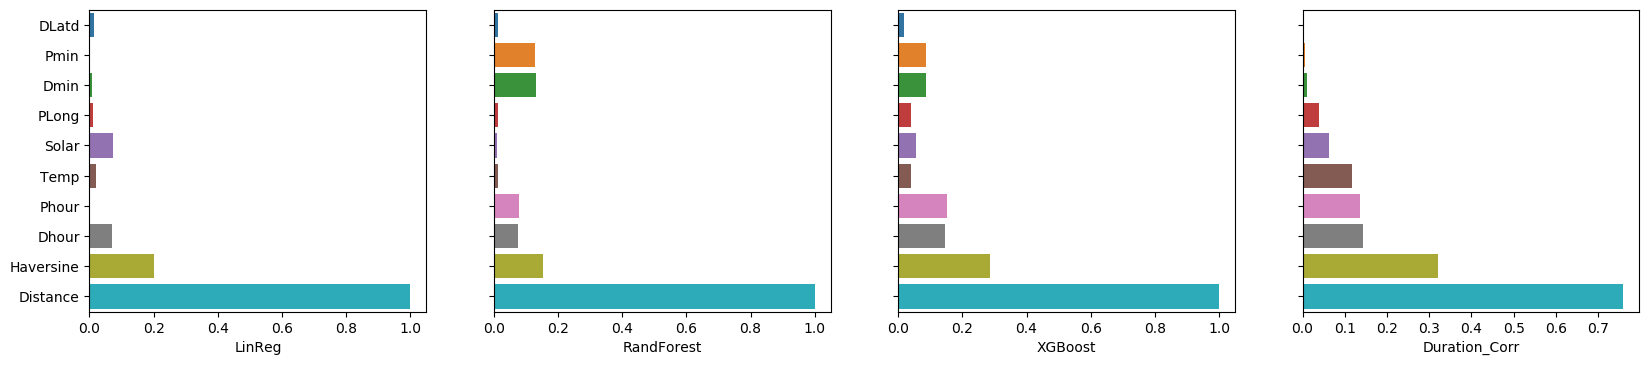

In [17]:
feature_importances = feature_importances.sort_values('Duration_Corr')

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4), dpi=100, sharey=True)

sns.barplot(y=feature_importances.index, x= feature_importances.LinReg, ax=ax[0])
sns.barplot(y=feature_importances.index, x= feature_importances.RandForest, ax=ax[1])
sns.barplot(y=feature_importances.index, x= feature_importances.XGBoost, ax=ax[2])
sns.barplot(y=feature_importances.index, x= feature_importances.Duration_Corr, ax=ax[3]);

## Hyperparameters Tuning